# Import packages

In [1]:
# Data manipulation
import datetime as dt
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # Remove column display limit
import pandas_ta as ta
from pandas.tseries.offsets import DateOffset


# Stats
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid') # Set Seaborn style
import matplotlib.patches as mpatches

import mplfinance as mpf

# Data Fetch
import requests


# ETL

## API setup and configuration 

### Alpha Vantage

[Alpha Vantage API Documentation](https://www.alphavantage.co/documentation/#)

In [2]:
# Import dotenv_values and load the API key from .env file
from dotenv import dotenv_values 
secrets = dotenv_values("secrets/.env")
alpha_key = secrets["alphavantage_key"]

#### Search Endpoint

[Documentation](https://www.alphavantage.co/documentation/#symbolsearch)  

The Search Endpoint returns the best-matching symbols and market information based on keywords of your choice. The search results also contain match scores that provide you with the full flexibility to develop your own search and filtering logic.  

In [3]:
# Function to search for symbols based on a keyword
def av_search(keyword):
    """
    Search for stock symbols based on a given keyword using the Alpha Vantage API.

    Parameters:
    - keyword (str): The keyword to search for.

    Returns:
    - df_results (pandas.DataFrame): A DataFrame containing the best matches for the given keyword.
    """
    # Base URL for the Alpha Vantage SYMBOL_SEARCH function
    base_url = "https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={keyword}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL with the keyword and API key
    url = base_url.format(keyword=keyword, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)
    
    # Check for successful response (status code 200)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: HTTP {response.status_code}")

    # Parse the response as JSON
    response_json = response.json()
    
    # Extract the 'bestMatches' section to create a DataFrame
    best_matches = response_json.get('bestMatches', [])
    df_results = pd.DataFrame(best_matches)

    return df_results

#### Time Series Daily

[Documentation](https://www.alphavantage.co/documentation/#daily)  

This API returns raw (as-traded) daily time series (date, daily open, daily high, daily low, daily close, daily volume) of the global equity specified, covering 20+ years of historical data. The OHLCV data is sometimes called "candles" in finance literature. 

In [4]:
# Function to fetch daily stock data
def av_daily(symbol, output_size):
    """
    Fetch daily stock data from Alpha Vantage based on a symbol and output size.

    Parameters:
    - symbol (str): The stock symbol to fetch data for.
    - output_size (str): The amount of data to fetch. Can be 'compact' or 'full'.

    Returns:
    - ts_df (pandas.DataFrame): A DataFrame with the daily time series data.
    """
    # Base URL for the TIME_SERIES_DAILY function
    base_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={output_size}&apikey={apikey}"

    # API key for authentication
    api_key = alpha_key

    # Construct the full URL with the specified symbol and output size
    url = base_url.format(symbol=symbol, output_size=output_size, apikey=api_key)

    # Send HTTP GET request to fetch data
    response = requests.get(url)

    # Check for successful response (status code 200)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: HTTP {response.status_code}")

    # Parse the response as JSON
    data = response.json()

    # Extract the daily time series data
    time_series = data.get("Time Series (Daily)", {})

    # Create a DataFrame from the time series data
    ts_df = pd.DataFrame.from_dict(time_series, orient='index')

    # Convert the index to datetime for easier manipulation and analysis
    ts_df.index = pd.to_datetime(ts_df.index)

    # Return the resulting DataFrame
    return ts_df

## Fetching data

Because of the daily limit with Alpha Vantage's free API key, I'll save the results to a CSV file and comment out the code that fetches the data.

In [5]:
# Search for Microsoft ticker
ticker_search = av_search('Microsoft')
ticker_search

,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,MSF0.FRK,MICROSOFT CORP. CDR,Equity,Frankfurt,08:00,20:00,UTC+02,EUR,0.6429
1,MSFT,Microsoft Corporation,Equity,United States,09:30,16:00,UTC-04,USD,0.6154
2,0QYP.LON,Microsoft Corporation,Equity,United Kingdom,08:00,16:30,UTC+01,USD,0.6000
3,MSF.DEX,Microsoft Corporation,Equity,XETRA,08:00,20:00,UTC+02,EUR,0.6000
4,MSF.FRK,Microsoft Corporation,Equity,Frankfurt,08:00,20:00,UTC+02,EUR,0.6000
5,MSFT34.SAO,Microsoft Corporation,Equity,Brazil/Sao Paolo,10:00,17:30,UTC-03,BRL,0.6000


### 	Microsoft Corporation
**Ticker = "MSFT"**

In [6]:
# Set the company ticker symbol to "MSFT" for Microsoft
# This variable can be changed to analyze a different company later
ticker = "MSFT"
# Retrieve the ticker name
company_name = ticker_search.loc[ticker_search['1. symbol'] == ticker, '2. name'].iloc[0]


company_name

'Microsoft Corporation'

In [7]:
# # Fetch 'ticker' Data from Alpha Vantage API
# df = av_daily(ticker, 'full')

# df.head()

In [8]:
# # Save fetched data to csv
# df.to_csv("data/msft_20240502.csv")

In [9]:
# Load saved data
df = pd.read_csv("data/msft_20240502.csv", index_col=0)

# Remove the first 3 characters in the columns name 
df.columns = [col[3:] for col in df.columns]

# Set index as DateTime
df.index = pd.to_datetime(df.index)
# Sort the data
df.sort_index(ascending=True, inplace=True)


print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6164 entries, 1999-11-01 to 2024-05-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6164 non-null   float64
 1   high    6164 non-null   float64
 2   low     6164 non-null   float64
 3   close   6164 non-null   float64
 4   volume  6164 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 288.9 KB
None


,open,high,low,close,volume
1999-11-01,93.25,94.19,92.12,92.37,26630600
1999-11-02,92.75,94.50,91.94,92.56,23174500
1999-11-03,92.94,93.50,91.50,92.00,22258500
1999-11-04,92.31,92.75,90.31,91.75,27119700
1999-11-05,91.81,92.87,90.50,91.56,35083700


# Calculate features and technical indicators

## Price Direction (Target)

A binary indicator representing whether the closing price of a stock is higher than the previous day's closing price.  


This variable will be used as our target variable for predicting the stock's price movement from one day to the next.

In [10]:
# Add price direction binary column; 1 = close price higher than yesterday
df['price_direction'] = (df['close'].shift(1) < df['close']).astype(int)


df[['close', 'price_direction']].tail()

,close,price_direction
2024-04-25,399.04,0
2024-04-26,406.32,1
2024-04-29,402.25,0
2024-04-30,389.33,0
2024-05-01,394.94,1


## Garman-Klass Volatility

The Garman-Klass volatility formula estimates the annualized volatility of a financial asset using high, low, open, and close prices. It is considered an improvement over simple close-to-close volatility estimation because it incorporates additional information from the intraday price range.

The formula to calculate the Garman-Klass volatility is:

$$
\sigma_{GK} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \frac{1}{2} \ln\left( \frac{H_i}{L_i} \right)^2 - (2 \ln(2) - 1) \ln\left( \frac{C_i}{O_i} \right)^2 \right)}
$$


where:

- $n$ is the number of periods (e.g., trading days),
- $O_i$ represents the opening price for period $i$,
- $C_i$ represents the closing price for period $i$,
- $H_i$ represents the highest price during period $i$,
- $L_i$ represents the lowest price during period $i$.


In [11]:
# Define the Garman-Klass volatility function
def garman_klass(data):
    """
    Calculate the Garman-Klass volatility and add it to the DataFrame.

    Parameters:
    - data (pandas.DataFrame): The DataFrame containing stock data with 'high', 'low', 'open', and 'close' columns.

    Returns:
    - data (pandas.DataFrame): The same DataFrame with added 'gk_volatility' column.
    """
    # Calculate the high-low component of Garman-Klass volatility
    high_low = 0.5 * np.square(np.log(data['high'] / data['low']))

    # Calculate the open-close component of Garman-Klass volatility
    open_close = (2 * np.log(2) - 1) * np.square(np.log(data['close'] / data['open']))

    # Calculate the Garman-Klass volatility
    gk_volatility = np.sqrt(high_low - open_close)

    # Add the calculated volatility as a new column to the DataFrame
    data['gk_volatility'] = gk_volatility

    # Return the DataFrame with the new column
    return data

In [12]:
# Calculate the G.K. Volatility
df = garman_klass(data=df)

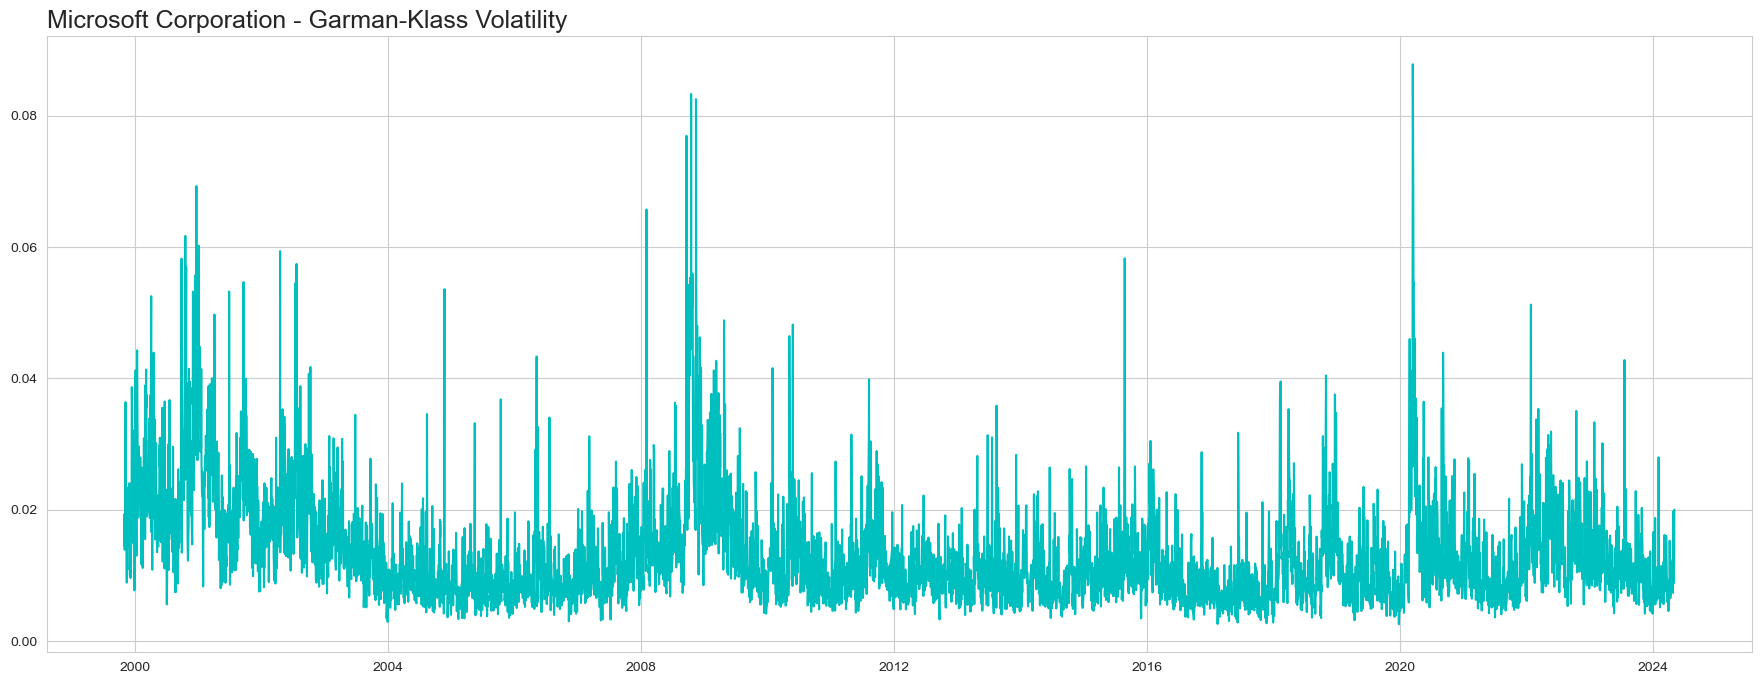

In [13]:
# Set figure size
plt.figure(figsize=(22, 8))

# Plot garman_klass volatility
plt.plot(df.index, df['gk_volatility'], color='c')

# Set title
plt.title(f'{company_name} - Garman-Klass Volatility',
          loc='left',
          fontsize=18
          )

# Show Y axis grid
plt.gca().yaxis.grid(True)

# Remove Y label 
plt.ylabel('')

plt.show();

### Key Events Behind Volatility Peaks:

1. **2008-2009: Great Recession**  
   The global financial crisis caused extreme market instability due to the collapse of major financial institutions, a housing market crash, and high uncertainty.

2. **2010: Flash Crash**  
   On May 6, there was a sudden and severe drop in U.S. stock markets, followed by a rapid rebound. This event was attributed to high-frequency trading, algorithmic anomalies, and market imbalances.

3. **2011: Occupy Wall Street Movement**  
   From September 17 to November 15, a movement protesting economic inequality and corporate influence took place, highlighting public discontent with the financial system. This led to further uncertainty in financial markets.

4. **2015: Chinese Stock Market Turmoil**  
   In 2015, the Chinese stock market experienced significant volatility, with sharp swings and a steep decline. The turmoil in China, one of the world's largest economies, caused global market instability.

5. **2020: COVID-19 Pandemic**  
   The COVID-19 pandemic caused significant market disruption starting in early 2020. Lockdowns, supply chain interruptions, and widespread uncertainty led to unprecedented volatility. The rollout of vaccines and evolving public health responses continued to impact markets throughout 2020 and into 2021.

## The Relative Strength Index (RSI)

The Relative Strength Index (RSI) is a momentum oscillator used to measure the speed and change of price movements.  

It ranges from 0 to 100 and is commonly used in technical analysis to identify overbought and oversold conditions in a market or stock. 

RSI is calculated by comparing the average gains and losses over a specific period, typically 14 days. The formula for RSI is:

$$
\text{RSI} = 100 - \frac{100}{1 + \text{RS}}
$$

Where:

- **Relative Strength**: $ \text{RS} = \frac{\text{Average Gain}}{\text{Average Loss}}$
- **Average Gain**: The average of the gains over the period.
- **Average Loss**: The average of the losses over the same period.

We are using pandas_ta (Pandas Technical Analysis) library to calculate the RSI.

In [14]:
# Calculate the RSI
df['rsi'] = ta.rsi(close=df['close'], length=14)

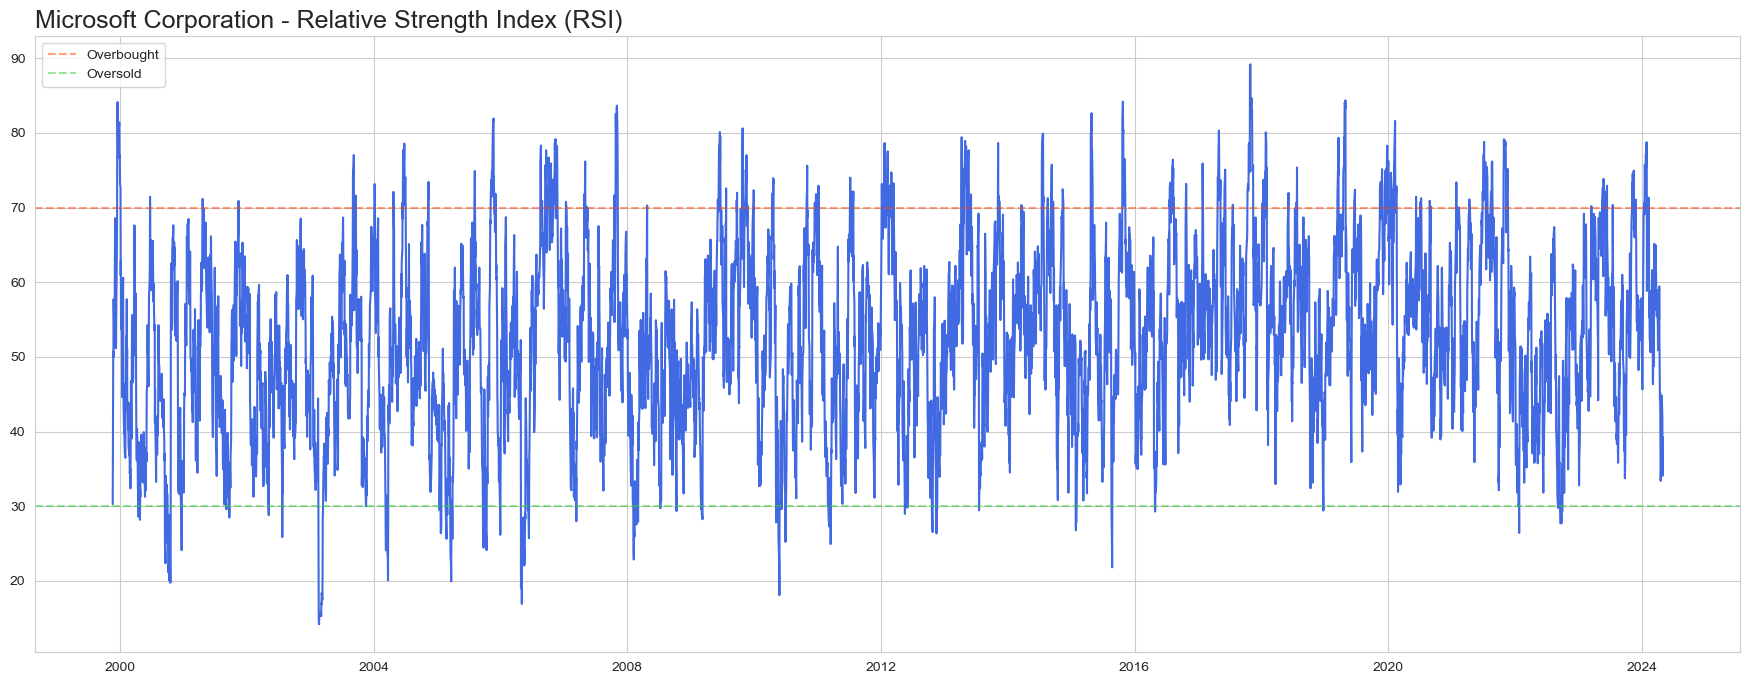

In [15]:
# Set figure size
plt.figure(figsize=(22, 8))

# Plot Relative Strength Index
sns.lineplot(data=df, x=df.index, y=df['rsi'], color='royalblue')

# Set constant lines on the 70, 30 RSI
plt.axhline(70, color='orangered', linestyle='--', label='Overbought', alpha=0.5)
plt.axhline(30, color='limegreen', linestyle='--', label='Oversold', alpha=0.5)

# Set title and legend
plt.legend(loc='upper left')
plt.title(f'{company_name} - Relative Strength Index (RSI)',
          loc='left',
          fontsize=18
          )

# Remove Y label
plt.ylabel('')

plt.show();

### Interpretation of Relative Strength Index (RSI):
- ***An RSI above 70 often indicates an overbought condition***, suggesting a potential reversal or correction, while an RSI ***below 30 indicates an oversold condition***, possibly signaling a rebound.  

## Bollinger Bands

Bollinger Bands are used to gauge volatility and identify potential overbought or oversold conditions.

Components of Bollinger Bands
* **Middle Band**: A simple moving average, typically a 20-period SMA.
* **Upper Band**: The middle band plus a multiple of the standard deviation (commonly 2 times the standard deviation).
* **Lower Band**: The middle band minus the same multiple of the standard deviation.

In [16]:
# Define the Bollinger Bands function
def bollinger_bands(data, length, std):
    """
    Calculate Bollinger Bands and add it to the DataFrame.

    Parameters:
    - data (pandas.DataFrame): The input data with a 'close' column.
    - length (int): The length of the period for the Bollinger Bands.
    - std (float): The standard deviation for the Bollinger Bands.

    Returns:
    - data (pandas.DataFrame): The same DataFrame with added Bollinger Bands columns.
    """
    # Sort the data index in ascending order
    data.sort_index(ascending=True, inplace=True)

    # Calculate Bollinger Bands
    bol_bands = ta.bbands(close=data['close'], length=length, std=std)

    # Dictionary to rename Bollinger Bands columns
    bb_names = {
        "BBL_20_2.0": "bb_low",
        "BBM_20_2.0": "bb_mid",
        "BBU_20_2.0": "bb_upper",
        "BBB_20_2.0": "bb_basis",
        "BBP_20_2.0": "bb_percentage"
    }

    # Rename the Bollinger Bands columns
    bol_bands.rename(columns=bb_names, inplace=True)

    # Ensure indices are aligned before concatenation
    bol_bands.sort_index(ascending=True, inplace=True)
    bol_bands = bol_bands.reindex(data.index)

    # If Bollinger Bands columns exist, replace their values
    existing_columns = [col for col in bol_bands.columns if col in data.columns]
    if existing_columns:
        data[existing_columns] = bol_bands[existing_columns]
    else:
        # If not, concatenate data and bol_bands
        data = pd.concat([data, bol_bands], axis=1)

    return data

In [17]:
# Calculate the Bollinger Bands
df = bollinger_bands(data=df, length=20, std=2)

df.tail()

,open,high,low,close,volume,price_direction,gk_volatility,rsi,bb_low,bb_mid,bb_upper,bb_basis,bb_percentage
2024-04-25,394.03,399.8899,388.0300,399.04,40586450,0,0.019787,37.325980,397.142635,415.7310,434.319365,8.942497,0.051036
2024-04-26,412.17,413.0000,405.7601,406.32,29694654,1,0.008801,44.584077,396.138028,415.0110,433.883972,9.095167,0.269750
2024-04-29,405.25,406.3200,399.1900,402.25,19582091,0,0.011635,41.678108,394.776920,413.8950,433.013080,9.238130,0.195445
2024-04-30,401.49,402.1600,389.1700,389.33,28781374,0,0.013177,34.083461,390.737403,412.2895,433.841597,10.454837,-0.032651
2024-05-01,392.61,401.7199,390.3100,394.94,23562481,1,0.020040,39.259120,388.544742,411.0140,433.483258,10.933573,0.142311


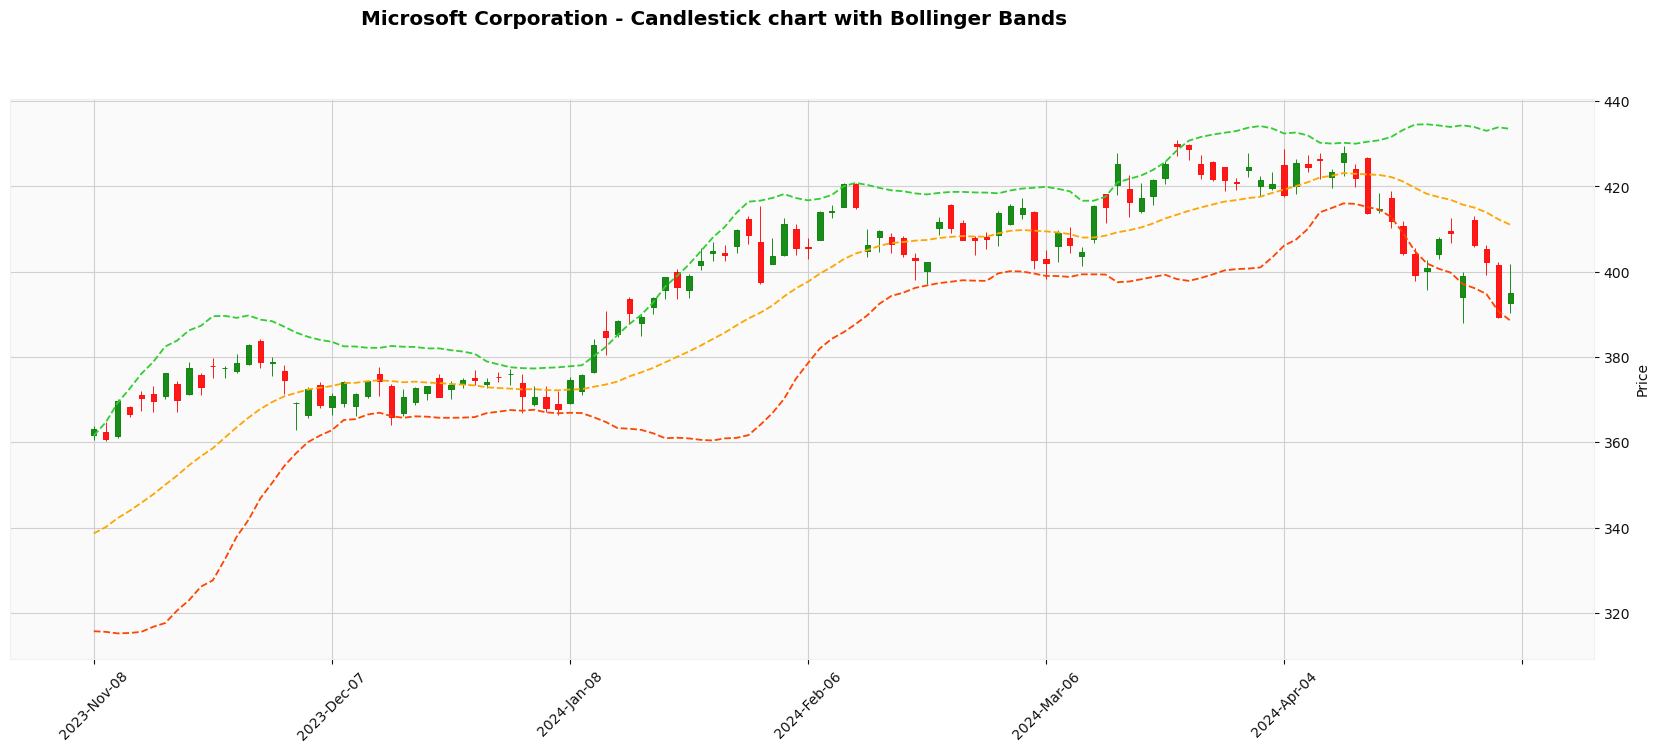

In [18]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Create a custom plot style for mplfinance
mc = mpf.make_marketcolors(
    up='green', down='red', edge='inherit', wick='inherit', volume='in'
)

s = mpf.make_mpf_style(
    base_mpf_style='yahoo', marketcolors=mc, y_on_right=True, gridstyle='-'
)

# Plot Candlestick Chart with bollinger bands
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    addplot=[
        mpf.make_addplot(plot_data['bb_low'], color='orangered', linestyle='--'),
        mpf.make_addplot(plot_data['bb_mid'], color='orange', linestyle='--'),
        mpf.make_addplot(plot_data['bb_upper'], color='limegreen', linestyle='--'),

    ],
    title=f'{company_name} - Candlestick chart with Bollinger Bands',
    figsize=(22, 8)
);

### Interpreting Bollinger Bands:
- **Price Exceeding Bands**: If the price moves outside the bands, it may indicate that the asset is overbought (above the upper band) or oversold (below the lower band).
- **Band Expansion and Contraction**: Wider bands indicate higher volatility, while narrower bands indicate lower volatility.
- **Reversion to the Mean**: Prices tend to revert to the middle band after touching or exceeding the upper or lower bands. 

## Average True Range (ATR)

ATR measures the average range of price movements over a specified period, typically 14 days. It takes into account the following ranges for each period (day):

- **High-Low**: The range within the same trading session.
- **High-Close (Previous Day)**: If there's a gap between the previous close and the current high.
- **Low-Close (Previous Day)**: If there's a gap between the previous close and the current low.  

ATR provides a more complete measure of volatility by considering both intraday price movements and gaps between trading sessions.


In [19]:
# Define the Average True Range function
def average_true_range(data, length):
    """
    Calculate the Average True Range (ATR) and add it to the DataFrame.

    Parameters:
    - data (pandas.DataFrame): The input data with 'high', 'low', and 'close' columns.
    - length (int): The period for the ATR calculation.

    Returns:
    - data (pandas.DataFrame): The same DataFrame with added 'atr' column.
    """
    # Sort the data index to ensure consistency
    data.sort_index(ascending=True, inplace=True)

    # Calculate the ATR with the specified period length
    atr = ta.atr(
        high=data['high'],
        low=data['low'],
        close=data['close'],
        length=length
    )

    # Align indices before concatenation or updating
    atr.sort_index(ascending=True, inplace=True)
    atr = atr.reindex(data.index)

    # Check if 'atr' already exists, then replace its values
    if 'atr' in data.columns:
        data['atr'] = atr
    else:
        # If not, concatenate the new ATR to the existing DataFrame
        data = pd.concat([data, atr], axis=1)

    # Rename the ATR column if needed
    data.rename(columns={'ATRr_14': 'atr'}, inplace=True)

    return data

In [20]:
# Calculate the ATR
df = average_true_range(data=df, length=14)

df.tail()

,open,high,low,close,volume,price_direction,gk_volatility,rsi,bb_low,bb_mid,bb_upper,bb_basis,bb_percentage,atr
2024-04-25,394.03,399.8899,388.0300,399.04,40586450,0,0.019787,37.325980,397.142635,415.7310,434.319365,8.942497,0.051036,8.120843
2024-04-26,412.17,413.0000,405.7601,406.32,29694654,1,0.008801,44.584077,396.138028,415.0110,433.883972,9.095167,0.269750,8.537926
2024-04-29,405.25,406.3200,399.1900,402.25,19582091,0,0.011635,41.678108,394.776920,413.8950,433.013080,9.238130,0.195445,8.437360
2024-04-30,401.49,402.1600,389.1700,389.33,28781374,0,0.013177,34.083461,390.737403,412.2895,433.841597,10.454837,-0.032651,8.768977
2024-05-01,392.61,401.7199,390.3100,394.94,23562481,1,0.020040,39.259120,388.544742,411.0140,433.483258,10.933573,0.142311,9.027614


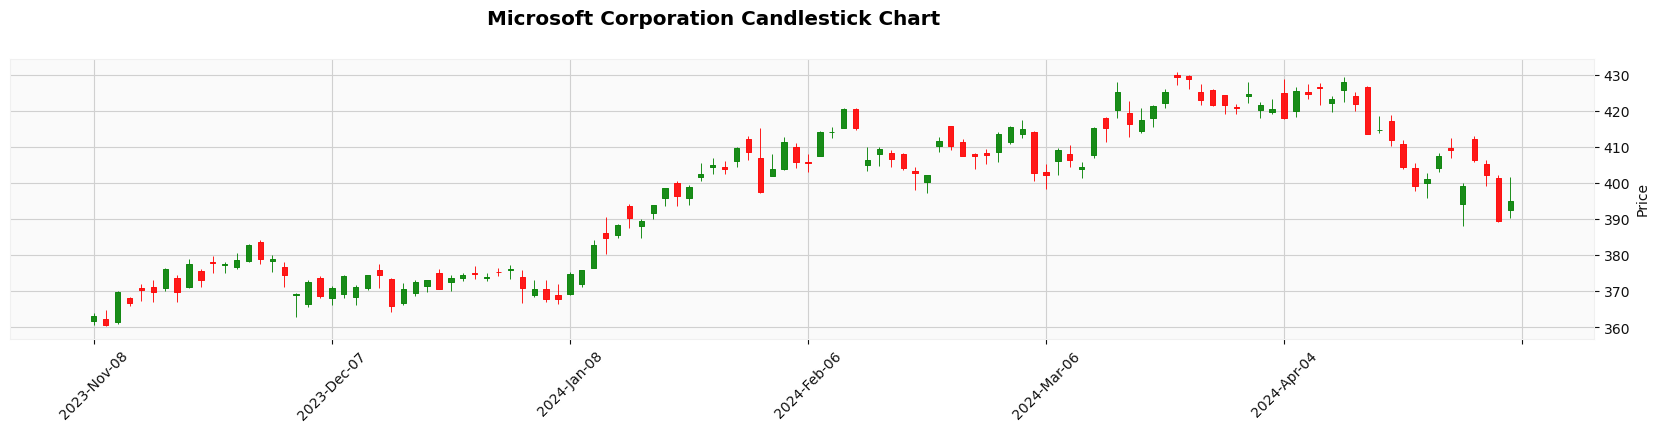

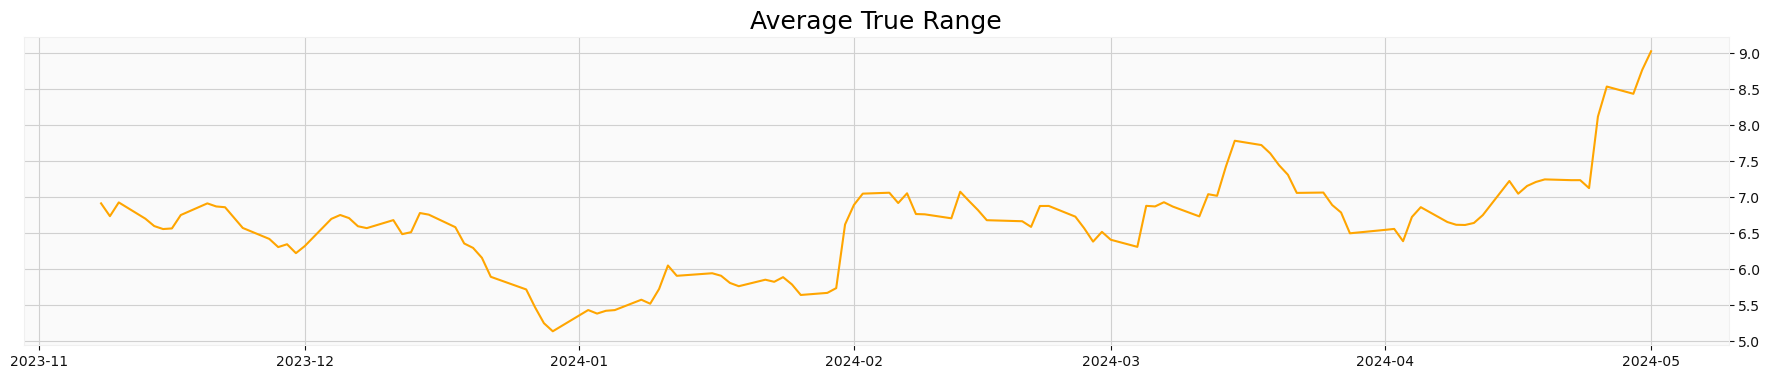

In [21]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick Chart 
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot Average True Range
ax.plot(plot_data.index, plot_data['atr'], color='orange')

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

# Set title
ax.set_title('Average True Range', loc='center', fontsize=18)

# Display the plot
plt.show();

### Interpreting ATR:

- **General Volatility Trend**: If ATR is increasing, it indicates rising market volatility. Conversely, a decreasing ATR signals lower volatility, indicating more stable price movements.

- **Trend Continuation or Reversal**: A sudden spike in ATR can signal a significant market event, suggesting a potential trend reversal or continuation. Pay attention to news events or announcements that could explain such spikes.

- **Assessing Market Sentiment**: Consistently high ATR may indicate uncertainty or market turbulence, while low ATR can suggest calm or consolidation.

- **Identifying Breakout Opportunities**: A sudden increase in ATR, especially after a period of low volatility, can signal a breakout from a consolidation pattern. This can be a key point for potential trading opportunities.

## Moving Average Convergence Divergence (MACD)

the difference between two exponential moving averages (EMAs) and is accompanied by a signal line (another EMA) and a histogram.  

It consists of three key components:
* **MACD Line**: The difference between a fast EMA (typically 12-period) and a slow EMA (typically 26-period). This line is used to measure momentum.
* **Signal Line**: A 9-period EMA of the MACD line. This serves as a smoothing mechanism to generate buy and sell signals.
* **Histogram**: The difference between the MACD line and the signal line. The histogram indicates the strength of momentum and whether it's increasing or decreasing.

In [22]:
# Define the Moving Average Convergence Divergence (MACD) function
def moving_average_cd(data):
    """
    Calculate the Moving Average Convergence Divergence (MACD) and add it to the DataFrame.

    Parameters:
    - data (pandas.DataFrame): The input data with a 'close' column.

    Returns:
    - data (pandas.DataFrame): The same DataFrame with additional MACD columns.
    """
    # Sort the data index to ensure consistency
    data.sort_index(ascending=True, inplace=True)

    # Calculate the MACD with default parameters
    macd = data.ta.macd(close=data['close'])

    # Dictionary for renaming MACD columns
    macd_names = {
        "MACD_12_26_9": "macd",
        "MACDh_12_26_9": "macd_hist",
        "MACDs_12_26_9": "macd_signal"
    }

    # Rename the MACD columns for clarity
    macd.rename(columns=macd_names, inplace=True)

    # Ensure indices are aligned before concatenation or updating
    macd.sort_index(ascending=True, inplace=True)
    macd = macd.reindex(data.index)

    # If MACD columns exist, update their values
    existing_columns = [col for col in macd.columns if col in data.columns]
    if existing_columns:
        data[existing_columns] = macd[existing_columns]
    else:
        # If not, concatenate data and macd
        data = pd.concat([data, macd], axis=1)

    return data

In [23]:
# Calculate the MACD
df = moving_average_cd(data=df)
df.tail().iloc[:, -3:]

,macd,macd_hist,macd_signal
2024-04-25,-3.808637,-2.276267,-1.532371
2024-04-26,-3.760728,-1.782686,-1.978042
2024-04-29,-4.005008,-1.621572,-2.383435
2024-04-30,-5.181409,-2.238379,-2.943030
2024-05-01,-5.596522,-2.122794,-3.473729


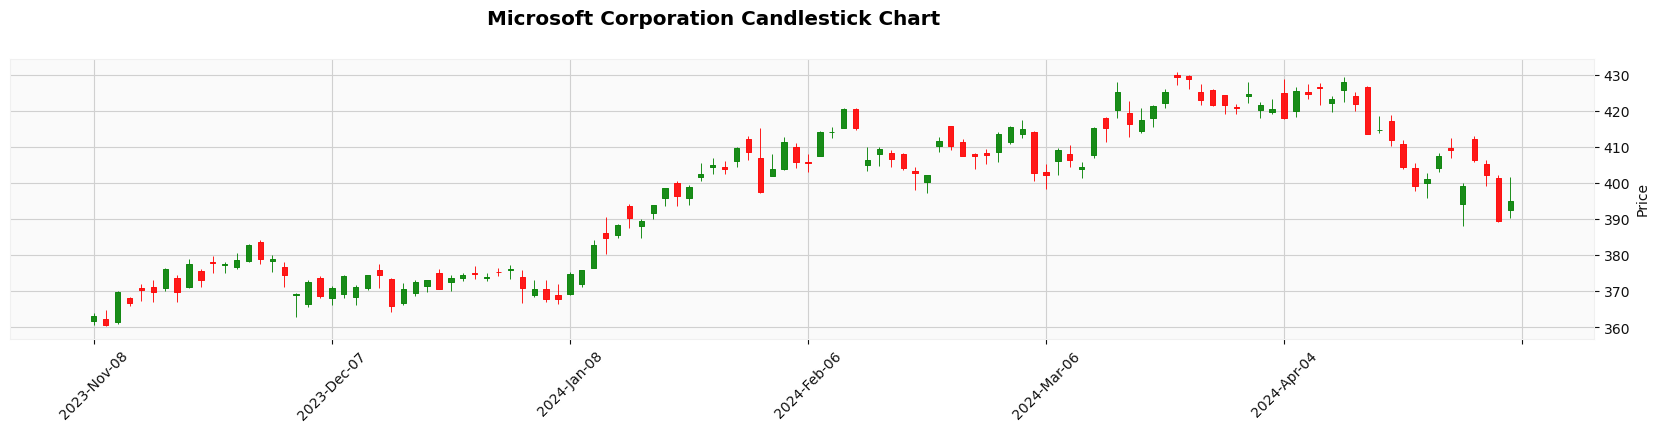

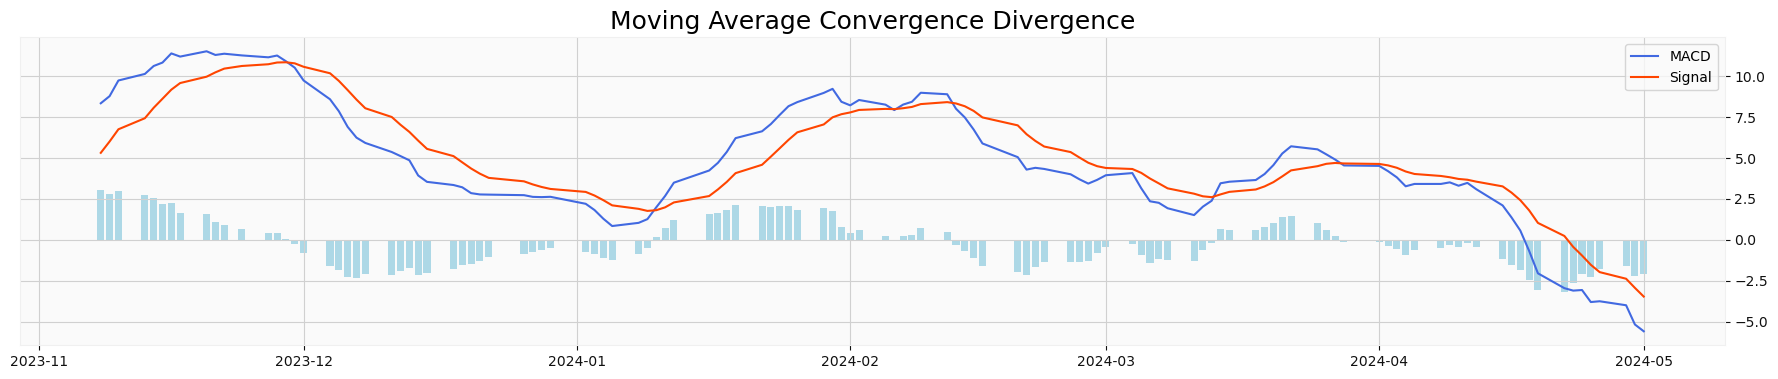

In [24]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)


# Plot Candlestick Chart 
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    title= f'{company_name} Candlestick Chart',
    figsize=(22, 4)
)

# Set figure size
plt.figure(figsize=(22, 4))

# Create a new subplot
ax = plt.gca()

# Plot MACD, MACD Signal, and MACD histogram
ax.plot(plot_data.index, plot_data['macd'], color='royalblue', label='MACD')
ax.plot(plot_data.index, plot_data['macd_signal'], color='orangered', label='Signal')
ax.bar(plot_data.index, plot_data['macd_hist'], color='lightblue')

# Show Legend
ax.legend(loc='upper right')

# Set title
ax.set_title('Moving Average Convergence Divergence', loc='center', fontsize=18)

# Move Y axis ticks to the right
ax.yaxis.tick_right()
# Set label position to the right
ax.yaxis.set_label_position("right")

plt.show();

### Interpreting MACD:

- **Crossovers between MACD and Signal Line**:
  - When the MACD line crosses above the signal line, it may indicate a buy signal, suggesting a potential upward trend.
  - Conversely, when the MACD line crosses below the signal line, it may indicate a sell signal, suggesting a potential downward trend.

- **Position Relative to Zero Line**:
  - If the MACD line is above zero, it suggests a bullish market condition. This indicates that the shorter EMA is higher than the longer EMA, reflecting positive momentum.
  - If the MACD line is below zero, it suggests a bearish market condition, indicating negative momentum.

- **Histogram Analysis**:
  - The histogram represents the difference between the MACD line and the signal line. If the histogram is increasing (positive bars getting taller or negative bars getting shorter), it suggests strengthening momentum in the direction of the trend.
  - If the histogram is decreasing (positive bars getting shorter or negative bars getting taller), it suggests weakening momentum and could signal a potential trend reversal.

- **Magnitude of the Histogram**:
  - A larger magnitude of the histogram (either positive or negative) suggests higher volatility and stronger price movements.
  - Smaller magnitudes indicate lower volatility and more stable price movements.

- **Trend Confirmation**:
  - If the MACD line is above the signal line and the histogram is positive, it confirms a bullish trend.
  - If the MACD line is below the signal line and the histogram is negative, it confirms a bearish trend.

## Volume Weighted Average Price (VWAP)

Represents the average price at which a security is traded throughout the trading session, weighted by the volume of trades. It's often used by institutional traders and analysts to determine the true average price of a security over a given period, providing insights into buying or selling pressure.

The Volume Weighted Average Price (VWAP) formula:

$$
\text{VWAP} = \frac{{\sum (\text{typical price} \times \text{volume})}}{{\sum \text{volume}}}
$$

**Where**:
- **Typical price**: $ \text{typical price} = \frac{{\text{high} + \text{low} + \text{close}}}{3} $
- **Volume** represents the trading volume for each period.

- The numerator $ \sum (\text{typical price} \times \text{volume}) $ is the sum of the product of the typical price and the volume over a given period.
- The denominator $ \sum \text{volume} $ is the total trading volume over the same period.

In [25]:
def calculate_vwap(data, window_size):
    """
    Calculate the Volume-Weighted Average Price (VWAP) for a given data set and window size.

    Parameters:
    - data (pandas.DataFrame): The input data with 'high', 'low', 'close', and 'volume' columns.
    - window_size (int): The rolling window size to compute the VWAP.

    Returns:
    - pandas.DataFrame: The same input data with an additional 'vwap' column.
    """
    
    # Copy the input data to avoid modifying the original
    df = data.copy()

    # Calculate the Typical Price
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3

    # Calculate the rolling sum of typical price-volume products
    df['rolling_pv'] = (df['typical_price'] * df['volume']).rolling(window=window_size).sum()

    # Calculate the rolling sum of volume
    df['rolling_volume'] = df['volume'].rolling(window=window_size).sum()

    # Calculate VWAP
    df['vwap'] = df['rolling_pv'] / df['rolling_volume']

    # Add VWAP to the original data frame
    data['vwap'] = df['vwap']

    return data


In [26]:
# Calculate a 30-day rolling VWAP
df = calculate_vwap(data=df, window_size=30) 

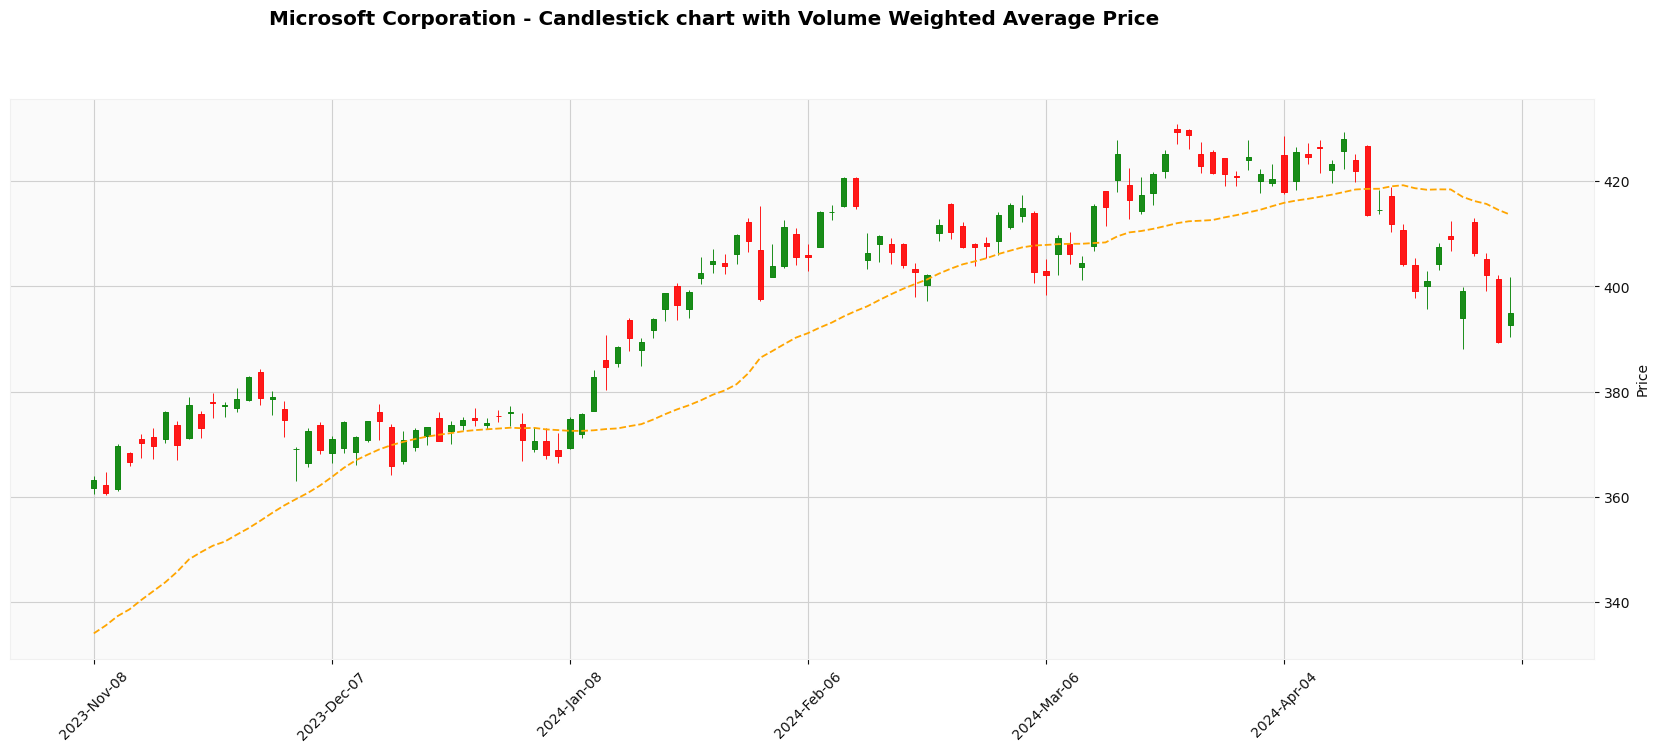

In [82]:
# Set the plot data to the last 120 days
plot_data = df.tail(120)

# Plot Candlestick chart with Volume Weighted Average Price
mpf.plot(
    plot_data,
    type='candle',
    style=s,
    ylabel='Price',
    addplot=[
        mpf.make_addplot(plot_data['vwap'], color='orange', linestyle='--', ylabel='VWAP')
    ],
    title=f'{company_name} - Candlestick chart with Volume Weighted Average Price',
    figsize=(22, 8)
);

### Interpreting Volume Weighted Average Price

- **Buyers and Sellers Sentiment**: VWAP can indicate buying or selling pressure during a trading session. If the price is above the VWAP, it generally suggests that there's buying pressure, indicating bullish sentiment. Conversely, if the price is below the VWAP, it suggests selling pressure or bearish sentiment.

- **Support and Resistance**: VWAP can act as a dynamic support or resistance level. When the price approaches the VWAP from above, it might find support, indicating that traders see it as a "fair value" point to buy. Similarly, if the price approaches from below, it can act as resistance, where traders might consider selling.

- **Trend Identification**: VWAP can help identify trends throughout the day. If the price consistently stays above the VWAP, it indicates an upward trend. If it stays below, it suggests a downward trend.

- **Relative Performance**: VWAP provides a benchmark to evaluate the relative performance of a stock. Institutions often use it to gauge whether they're getting a good deal compared to the average price paid by the rest of the market during a given period.


# Data Preparation and Feature Selection

This section outlines steps taken to clean and refine the dataset for modeling, including feature selection based on redundancy analysis to optimize model performance.

In [120]:
# Create a copy of df for our machine learning model
df_ml = df.copy()

# Drop missing values
df_ml.dropna(inplace=True)
df_ml.isnull().sum()

open               0
high               0
low                0
close              0
volume             0
price_direction    0
gk_volatility      0
rsi                0
bb_low             0
bb_mid             0
bb_upper           0
bb_basis           0
bb_percentage      0
atr                0
macd               0
macd_hist          0
macd_signal        0
vwap               0
dtype: int64

## Identifying and Removing Redundant Features

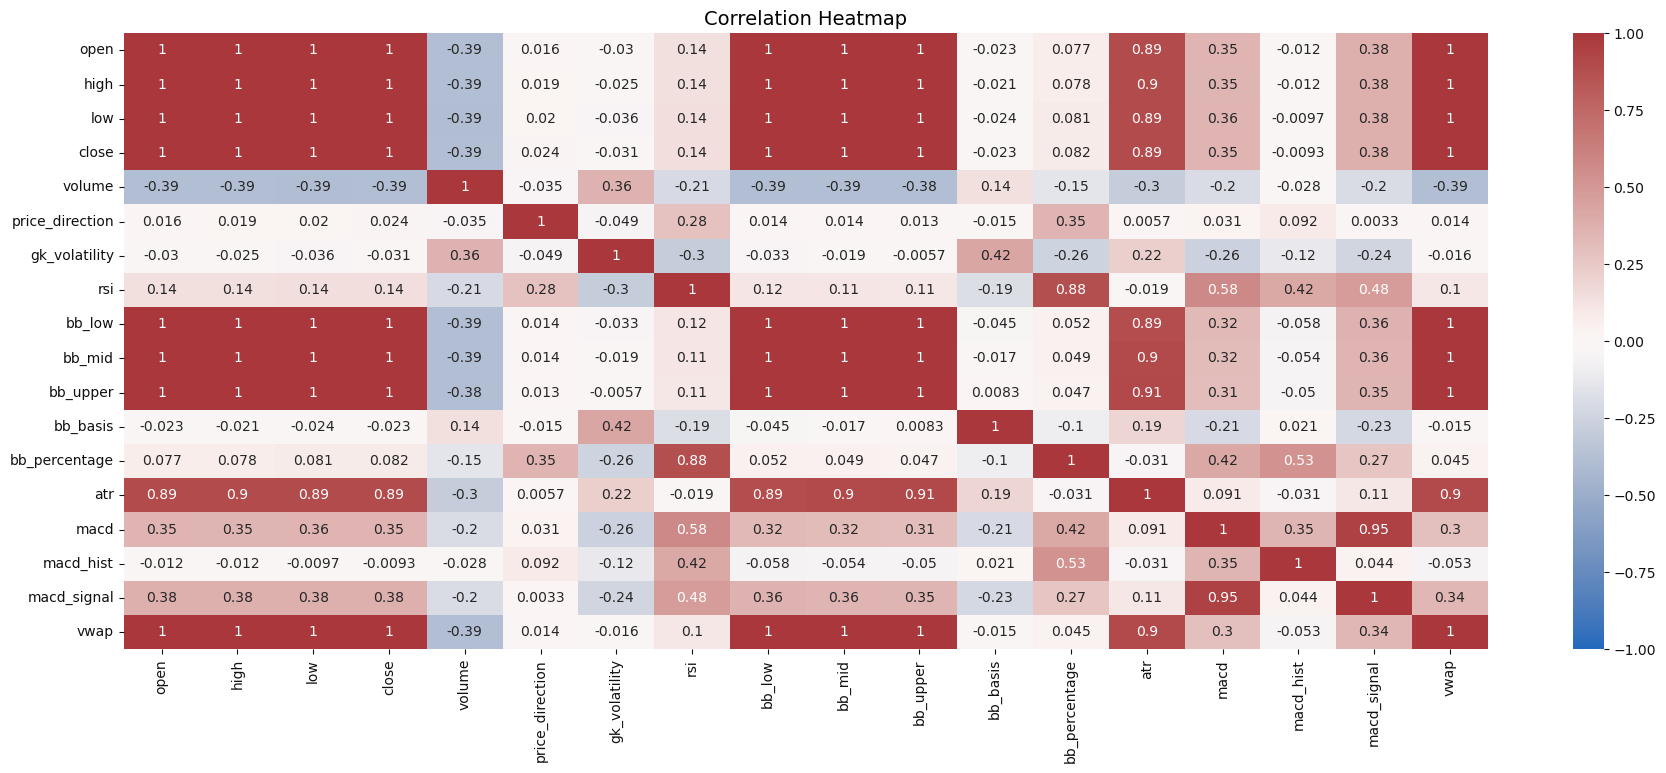

In [116]:
# Set figure size
plt.figure(figsize=(22, 8))

# Plot Correlation heatmap
sns.heatmap(df_ml.corr(),
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      cmap=sns.color_palette("vlag", as_cmap=True)
                      )

# Set plot title and labels
plt.title('Correlation Heatmap', fontsize= 14)


plt.show();

In [117]:
# List of columns to drop
drop_cols = ['high', 'low', 'open', 'close', 'volume', 'bb_low', 'bb_upper', 'bb_mid', 'macd_signal', 'macd_hist']

# Drop columns
df_ml.drop(columns=drop_cols, inplace=True)

df_ml.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6131 entries, 1999-12-17 to 2024-05-01
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price_direction  6131 non-null   int32  
 1   gk_volatility    6131 non-null   float64
 2   rsi              6131 non-null   float64
 3   bb_basis         6131 non-null   float64
 4   bb_percentage    6131 non-null   float64
 5   atr              6131 non-null   float64
 6   macd             6131 non-null   float64
 7   vwap             6131 non-null   float64
dtypes: float64(7), int32(1)
memory usage: 407.1 KB


### Dropped Columns

- **'open', 'high', 'low', 'close', 'volume'**: These columns were dropped because the Volume Weighted Average Price (VWAP) already incorporates information from the open, high, low, close, and volume columns. Keeping these columns would introduce redundancy in our dataset.

- **'bb_low', 'bb_upper', 'bb_mid'**: These columns were dropped because the Bollinger Bands are calculated based on the simple moving average (SMA) over a period of closing prices. Therefore, keeping the individual band values would introduce redundancy in our dataset. Instead, we retained the 'bb_basis' and 'bb_percentage' columns, which provide information about the relationship between the close price and the Bollinger Bands.

- **'macd_signal', 'macd_hist'**: The MACD signal line and MACD histogram are components of the MACD indicator, which is already represented in our dataset by the 'macd' column. Therefore, keeping these columns would provide redundant information.